# Setup Notebook

* **Local Setup**: Put the notebook into a folder with zip/csv file (bypass the first cell of Task #1 if the data is already extracted).

In [0]:
%matplotlib inline

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Task #1

In [2]:
!unzip Musk1_HW2_data.zip

Archive:  Musk1_HW2_data.zip
replace Musk1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Musk1.csv               


In [3]:
# read csv data and assign meaningful names to columns
dataset = pd.read_csv('Musk1.csv', header=None)
dataset.columns = [ 'Bag Class', 'Bag ID' ] + [ 'Feature ' + str(i) for i in range(1, 167) ]

# visualize data for sanity check
dataset.head()

,Bag Class,Bag ID,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,Feature 9,Feature 10,Feature 11,Feature 12,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 21,Feature 22,Feature 23,Feature 24,Feature 25,Feature 26,Feature 27,Feature 28,Feature 29,Feature 30,Feature 31,Feature 32,Feature 33,Feature 34,Feature 35,Feature 36,Feature 37,Feature 38,...,Feature 127,Feature 128,Feature 129,Feature 130,Feature 131,Feature 132,Feature 133,Feature 134,Feature 135,Feature 136,Feature 137,Feature 138,Feature 139,Feature 140,Feature 141,Feature 142,Feature 143,Feature 144,Feature 145,Feature 146,Feature 147,Feature 148,Feature 149,Feature 150,Feature 151,Feature 152,Feature 153,Feature 154,Feature 155,Feature 156,Feature 157,Feature 158,Feature 159,Feature 160,Feature 161,Feature 162,Feature 163,Feature 164,Feature 165,Feature 166
0,1,1,42,-198,-109,-75,-117,11,23,-88,-28,-27,-232,-212,-66,-286,-287,-300,-57,-75,-192,-184,-66,-18,-50,111,110,18,-18,-127,25,63,-117,-114,-47,9,-135,26,-175,73,...,35,51,11,-187,13,-138,-67,-163,-201,-19,45,-115,-11,-37,-100,77,78,60,-178,-102,-118,-33,-104,41,-77,-120,-111,-168,-54,-195,-238,-74,-129,-120,-38,30,48,-37,6,30
1,1,1,42,-191,-142,-65,-117,55,49,-170,-45,5,-325,-115,-107,-281,-257,-303,54,-154,-101,-47,-31,-28,1,191,72,-38,50,-64,-63,98,-117,-113,-46,2,-135,25,-159,1,...,-26,75,-107,-187,13,-138,-77,-129,-224,-89,51,-70,-19,-35,-29,3,43,10,-178,-102,-119,-57,-70,53,-77,-123,-111,-168,-54,-195,-238,-302,60,-120,-39,31,48,-37,5,30
2,1,1,42,-191,-142,-75,-117,11,49,-161,-45,-28,-278,-115,-67,-274,-285,-303,53,-154,-100,-183,-31,-28,1,110,110,-38,51,-64,25,63,-117,-113,-47,10,-135,26,-175,2,...,35,51,11,-187,13,-138,-77,-129,-221,-89,52,-71,-19,-35,-29,3,43,10,-178,-102,-118,-57,-70,54,-77,-120,-111,-168,-54,-195,-238,-73,-127,-120,-38,30,48,-37,5,31
3,1,1,42,-198,-110,-65,-117,55,23,-95,-28,5,-301,-212,-107,-280,-284,-301,-56,-74,-192,-46,-66,-19,-50,191,73,18,-19,-128,-63,98,-117,-113,-46,3,-135,25,-159,73,...,-27,76,-108,-187,13,-138,-67,-163,-201,-19,45,-115,-10,-37,-100,76,78,59,-178,-102,-118,-33,-104,41,-77,-123,-111,-168,-54,-195,-238,-302,60,-120,-39,30,48,-37,6,30
4,1,2,42,-198,-102,-75,-117,10,24,-87,-28,-28,-233,-212,-67,-286,-286,-299,-57,-74,-191,-182,-66,-18,-50,109,111,18,-18,-128,25,63,-117,55,-28,10,-131,66,-175,73,...,36,51,12,-187,17,-138,-67,-163,-201,-20,45,-116,-10,-37,-99,76,79,60,-177,-102,-118,-33,-104,41,-66,-120,-111,-120,97,-121,-238,-73,-127,51,128,144,43,-30,14,26


PCA - Explained Variance Ratio:
[0.40649539 0.12982484]
MDS - Stress (Normalized)
0.06750178562673498


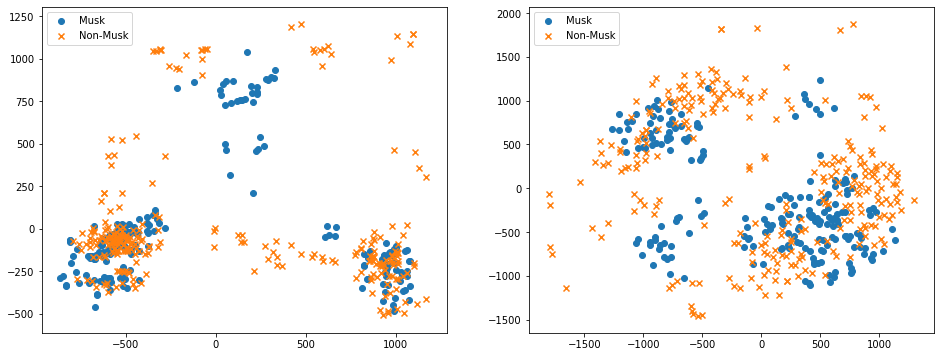

In [4]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform

COMPONENTS = 2

# slice class & id
features = dataset[dataset.columns[2:]]

# retrieve labels
labels = dataset['Bag Class']

# apply both pca & mds to given features
def pca_mds(features, labels, components=COMPONENTS, verbose=1):
    # get musk and non-musk ids
    musk_ids = labels == 1
    nonmusk_ids = ~musk_ids

    # apply pca
    pca = PCA(n_components=components)
    pca_features = pca.fit_transform(features)

    # print pca metrics
    if verbose > 0:
        print('PCA - Explained Variance Ratio:')
        print(pca.explained_variance_ratio_)

    # apply mds
    mds = MDS(n_components=components)
    mds_features = mds.fit_transform(features)

    # print mds metrics
    if verbose > 0:
        print('MDS - Stress (Normalized)')
        print(mds.stress_ / (np.sum(pdist(features, 'euclidean', p=2) ** 2)))

    # plot results
    if verbose > 0:
        if components > 2:
            print('dimension/component should be 2 for the visualization part.')
        else:
            fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

            # plot pca
            axs[0].scatter(pca_features[musk_ids, 0], pca_features[musk_ids, 1], marker='o')
            axs[0].scatter(pca_features[nonmusk_ids, 0], pca_features[nonmusk_ids, 1], marker='x')
            axs[0].legend(['Musk', 'Non-Musk'])

            # plot mds
            axs[1].scatter(mds_features[musk_ids, 0], mds_features[musk_ids, 1], marker='o')
            axs[1].scatter(mds_features[nonmusk_ids, 0], mds_features[nonmusk_ids, 1], marker='x')
            axs[1].legend(['Musk', 'Non-Musk'])

    return pca_features, mds_features

_, _ = pca_mds(features, labels)

We see that neither PCA or MDS achieves reasonable clustering when we use dimensions/components = 2. Expanding to components = 5, we see that PCA explains %70 variance whereas MDS - Stress value is decreased significantly which indicates significantly better fit. Since, we can't visualize the dimensions, we can't develop visual intuition for that case.

PCA - Explained Variance Ratio:
[0.3234942  0.21480017]
MDS - Stress (Normalized)
0.04716805234074893


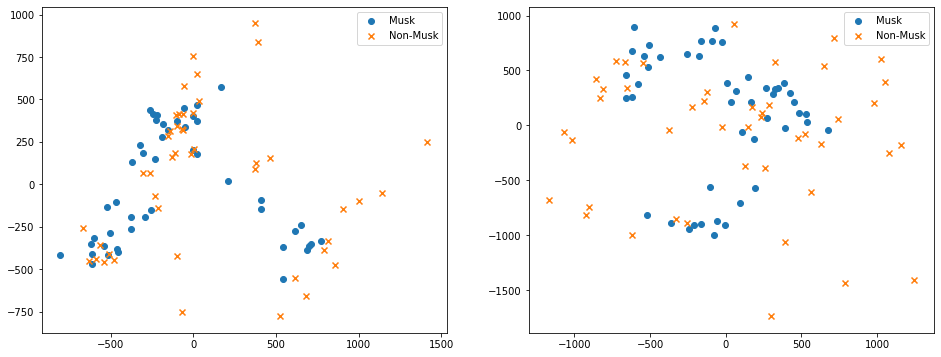

In [5]:
# take bag-wise means as features
features = dataset.groupby('Bag ID').mean()

# retrieve labels
labels = features['Bag Class'].values

# slice class & id
features = features[features.columns[2:]]

# apply pca & mds
_, _ = pca_mds(features, labels)

We observe that both explained variance ratio (PCA) and stress (MDS) metrics (for both dimensions/components = 2 or 5) are better or at least at the comparable levels when we use mean feature vectors as bag-level representation. Visually we are still not convinced that we have successful clustering in dimensions/components = 2 scenario. However, observed metrics indicates that mean feature vector does not result in great amount of information loss.

PCA - Explained Variance Ratio:
[0.33474888 0.22526786]
MDS - Stress (Normalized)
0.04546833918609921


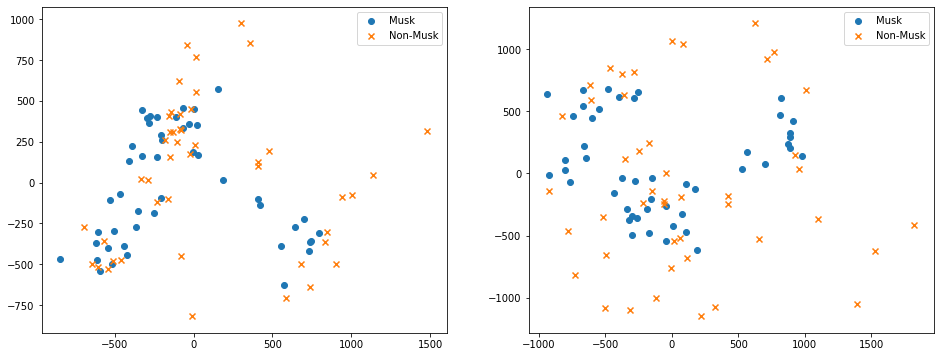

In [6]:
FEATURES = 10

# apply mds to get new representation for each instance
features = dataset[dataset.columns[2:]]
labels = dataset['Bag Class']
_, mds_features = pca_mds(features, labels, components=FEATURES, verbose=0)

# take mean of instances as bag representation
features = []
labels = []
for index, group in dataset.groupby(['Bag Class', 'Bag ID']):
    indices = group.index.tolist()
    features.append( np.mean(mds_features[indices, ...], axis=0) )
    labels.append(index[0])

features = np.asarray(features)
labels = np.asarray(labels)

_, _ = pca_mds(features, labels, components=2)

**Bonus:** We might take the mean feature vector in the MDS reduced feature space instead of directly taking the mean in our initial feature space. We observe that this provides a very very tiny improvement over our initial mean trial.

# Task #2

In [7]:
!wget https://www.jpchacha.com/blog/content/00000002/lena_256.jpg

--2019-10-25 22:23:11--  https://www.jpchacha.com/blog/content/00000002/lena_256.jpg
Resolving www.jpchacha.com (www.jpchacha.com)... 64.64.8.139
Connecting to www.jpchacha.com (www.jpchacha.com)|64.64.8.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43438 (42K) [image/jpeg]
Saving to: ‘lena_256.jpg.1’

lena_256.jpg.1      100%[===================>]  42.42K  --.-KB/s    in 0.06s   

2019-10-25 22:23:11 (742 KB/s) - ‘lena_256.jpg.1’ saved [43438/43438]



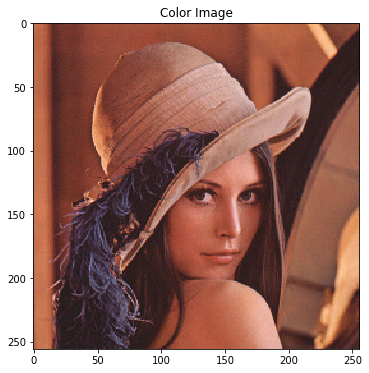

In [8]:
# read and resize image
image = cv2.imread('lena_256.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (256, 256))

# normalize image to [0,1] range
image = image / 255.0

# display image
plt.figure(figsize=(6,6))
plt.title('Color Image')
plt.imshow(image)
plt.show()

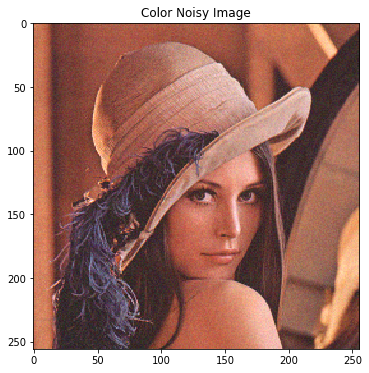

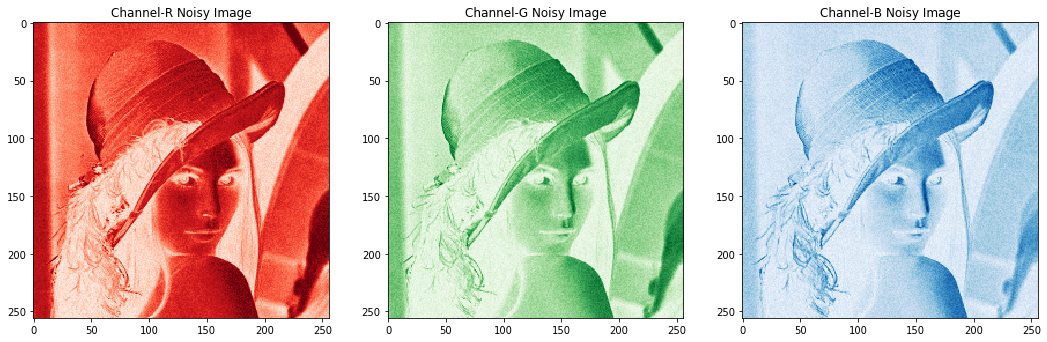

In [9]:
NOISE_MIN = 0
NOISE_MAX = 0.1

# add random noise
image_noisy = image + np.random.uniform(NOISE_MIN, NOISE_MAX, (256, 256, 3))
image_noisy = np.clip(image_noisy, 0, 1)

# display image
plt.figure(figsize=(6, 6))
plt.title('Color Noisy Image')
plt.imshow(image_noisy)
plt.show()

# display each channel seperately
channels = [ 'R', 'G', 'B' ]
colors = [ 'Reds', 'Greens', 'Blues' ]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
for i in range(3):
    axs[i].set_title('Channel-' + channels[i] + ' Noisy Image')
    axs[i].imshow(image_noisy[..., i], cmap=colors[i])
fig.show()

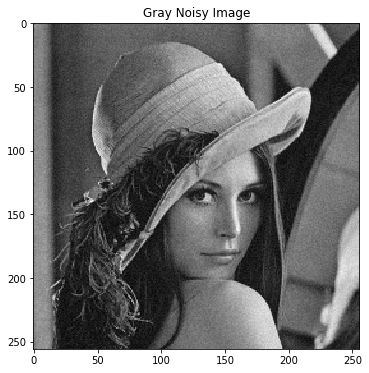

In [10]:
PATCH_SHAPE = (25, 25)

# turn image to grayscale
image_gray = cv2.cvtColor(image_noisy.astype('float32'), cv2.COLOR_RGB2GRAY)

# display image
plt.figure(figsize=(6, 6))
plt.title('Gray Noisy Image')
plt.imshow(image_gray, cmap='gray')
plt.show()

# extract patches
patches = []
for i in range(PATCH_SHAPE[0], image_gray.shape[0]+1):
    for j in range(PATCH_SHAPE[1], image_gray.shape[1]+1):
        patches.append( image_gray[i-PATCH_SHAPE[0]:i, j-PATCH_SHAPE[1]:j].flatten() )
patches = np.stack(patches)

PCA - Explained Variance Ratio
[0.5260912  0.14018309 0.05741275]


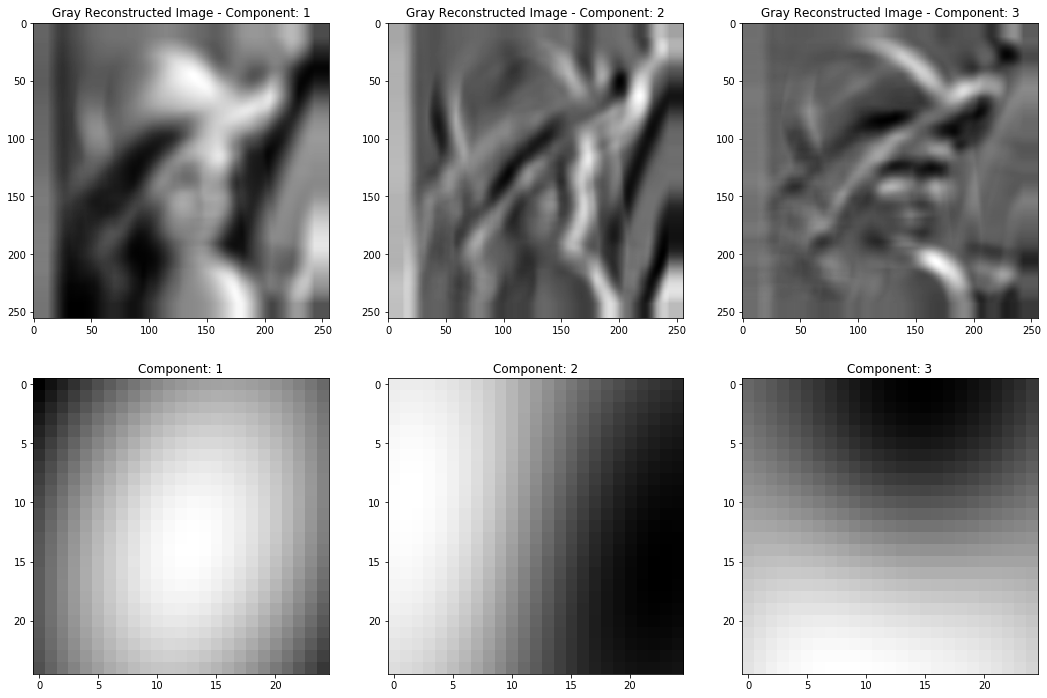

In [11]:
from sklearn.decomposition import PCA

COMPONENTS = 3

# apply pca
pca = PCA(n_components = COMPONENTS)
pca_features = pca.fit_transform(patches)

# comment on pca results
print('PCA - Explained Variance Ratio')
print(pca.explained_variance_ratio_)

# reconstruct image
patch_w = image.shape[0] - PATCH_SHAPE[0] + 1
patch_h = image.shape[1] - PATCH_SHAPE[1] + 1

# create figure
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

# iterate over components
for k in range(3):
    image_const = np.zeros(shape=(image_gray.shape))
    for i in range(image_gray.shape[0]):
        # interpolate to closest patch if required
        i_ind = max(0, i - PATCH_SHAPE[0] // 2)
        i_ind = min(patch_w-1, i_ind)
        for j in range(image_gray.shape[1]):
            # interpolate to closest patch if required
            j_ind = max(0, j - PATCH_SHAPE[1] // 2)
            j_ind = min(patch_h-1, j_ind)

            # get the associated component
            image_const[i, j] = pca_features[i_ind * patch_w + j_ind, k]

    # display reconstructed image
    axs[0, k].set_title('Gray Reconstructed Image - Component: ' + str(k+1))
    axs[0, k].imshow(image_const, cmap='gray')

    # display associated eigenvector
    axs[1, k].set_title('Component: ' + str(k+1))
    axs[1, k].imshow(pca.components_[k].reshape(PATCH_SHAPE), cmap='gray')

PCA with 3 components/dimensions explain %75 of the total variance. Considering possible complexities that mini 25x25 patterns in an image may exhibit, I will guess that capturing %75 of the variance with just 3 linear directions is quite successful. Moreover, we see that the visual output of individual components, especially the first one, are quite meaningful.